In [58]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

In [59]:
class ProcessingData:
    
    def __init__(self,filepath):
        with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            self.data = u.load()

    def fix_data(self, interval):
        """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
        converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
        don't have dt equal to interval.
        :param data:
        :param interval: float:minutes"""
        def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

        def h(x):
            if x == 1:
                return 1
            else:
                return 0

        def c(x):
            if x == 2:
                return 1
            else:
                return 0

        self.data["action"] = self.data["action"].map(f)
        self.data['action_heating'] = self.data["action"].map(h)
        self.data['action_cooling'] = self.data['action'].map(c)

        #print self.data.head()

        return self.data, self.data[self.data["dt"] == interval]
    
    def filter_data(self):
        self.data = self.data.drop(['t_next', 'dt', 'action', 'previous_action', 'action_duration', \
                                    'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        return self.data
    
    def drop_nan(self):
        self.data = self.data.dropna()
        return self.data


In [60]:
training = ProcessingData("../Data/avenal-animal-shelter_training_data.pkl")
training_data = training.fix_data(5)
training_data = training.filter_data()
training_data = training.drop_nan()

In [61]:
testing = ProcessingData("../Data/avenal-animal-shelter_test_data.pkl")
testing_data = testing.fix_data(5)
testing_data = testing.filter_data()
testing_data = testing.drop_nan()

In [66]:
def scaling(data):
    maxValues = []
    scaled = np.empty([data.shape[0], data.shape[1]])
    numSamples = data.shape[0]
    numFeatures = data.shape[1]
    dataValues = data.values
    dataValues = dataValues.astype('float32')
    for i in range(numFeatures):
        maxNum = max(dataValues[:,i])
        maxValues.append(maxNum)
        for j in range(numSamples):
            scaled[j,i] = dataValues[j,i]/maxNum
    return scaled, maxValues

In [64]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [67]:
train_scaled, train_scalers = scaling(training_data)
train_reframed = series_to_supervised(train_scaled, 2, 2)
train_reframed.drop(train_reframed.columns[-4:], axis=1, inplace=True)
train_reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var1(t+1)
2,0.856761,0.639420,0.0,0.0,0.0,0.856967,0.639420,0.0,0.0,0.0,0.856967,0.639621,0.0,0.0,0.0,0.856967
3,0.856967,0.639420,0.0,0.0,0.0,0.856967,0.639621,0.0,0.0,0.0,0.856967,0.640222,0.0,0.0,0.0,0.855734
4,0.856967,0.639621,0.0,0.0,0.0,0.856967,0.640222,0.0,0.0,0.0,0.855734,0.641024,0.0,0.0,0.0,0.856967
5,0.856967,0.640222,0.0,0.0,0.0,0.855734,0.641024,0.0,0.0,0.0,0.856967,0.641625,0.0,0.0,0.0,0.855734
6,0.855734,0.641024,0.0,0.0,0.0,0.856967,0.641625,0.0,0.0,0.0,0.855734,0.641826,0.0,0.0,0.0,0.856967


In [68]:
train_reframed.drop(train_reframed.columns[-5:-1], axis=1, inplace=True)
train_reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var1(t+1)
2,0.856761,0.639420,0.0,0.0,0.0,0.856967,0.639420,0.0,0.0,0.0,0.856967,0.856967
3,0.856967,0.639420,0.0,0.0,0.0,0.856967,0.639621,0.0,0.0,0.0,0.856967,0.855734
4,0.856967,0.639621,0.0,0.0,0.0,0.856967,0.640222,0.0,0.0,0.0,0.855734,0.856967
5,0.856967,0.640222,0.0,0.0,0.0,0.855734,0.641024,0.0,0.0,0.0,0.856967,0.855734
6,0.855734,0.641024,0.0,0.0,0.0,0.856967,0.641625,0.0,0.0,0.0,0.855734,0.856967


In [69]:
test_scaled, test_scalers = scaling(testing_data)
test_reframed = series_to_supervised(test_scaled, 2, 2)
test_reframed.drop(test_reframed.columns[-4:], axis=1, inplace=True)
test_reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var1(t+1)
2,0.941785,0.747789,0.0,0.0,0.0,0.941785,0.748107,0.0,0.0,0.0,0.944373,0.748422,0.0,0.0,0.0,0.944373
3,0.941785,0.748107,0.0,0.0,0.0,0.944373,0.748422,0.0,0.0,0.0,0.944373,0.748731,0.0,0.0,0.0,0.944373
4,0.944373,0.748422,0.0,0.0,0.0,0.944373,0.748731,0.0,0.0,0.0,0.944373,0.749038,0.0,0.0,0.0,0.944373
5,0.944373,0.748731,0.0,0.0,0.0,0.944373,0.749038,0.0,0.0,0.0,0.944373,0.748744,0.0,0.0,0.0,0.944373
6,0.944373,0.749038,0.0,0.0,0.0,0.944373,0.748744,0.0,0.0,0.0,0.944373,0.747249,0.0,0.0,0.0,0.944373


In [70]:
test_reframed.drop(test_reframed.columns[-5:-1], axis=1, inplace=True)
test_reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var1(t+1)
2,0.941785,0.747789,0.0,0.0,0.0,0.941785,0.748107,0.0,0.0,0.0,0.944373,0.944373
3,0.941785,0.748107,0.0,0.0,0.0,0.944373,0.748422,0.0,0.0,0.0,0.944373,0.944373
4,0.944373,0.748422,0.0,0.0,0.0,0.944373,0.748731,0.0,0.0,0.0,0.944373,0.944373
5,0.944373,0.748731,0.0,0.0,0.0,0.944373,0.749038,0.0,0.0,0.0,0.944373,0.944373
6,0.944373,0.749038,0.0,0.0,0.0,0.944373,0.748744,0.0,0.0,0.0,0.944373,0.944373


In [72]:
# split into input and outputs
train = train_reframed.values
test = test_reframed.values
train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]
train_y

array([[ 0.85696673,  0.85696673],
       [ 0.85696673,  0.85573369],
       [ 0.85573369,  0.85696673],
       ..., 
       [ 0.84956849,  0.85080147],
       [ 0.85080147,  0.85573369],
       [ 0.85573369,  0.85819978]])

In [73]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 2, 5))
test_X = test_X.reshape((test_X.shape[0], 2, 5))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(53183, 2, 5) (53183, 2) (13387, 2, 5) (13387, 2)


In [74]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [75]:
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 53183 samples, validate on 13387 samples
Epoch 1/50
 - 4s - loss: 0.0582 - acc: 0.4280 - val_loss: 0.0187 - val_acc: 0.4042
Epoch 2/50
 - 2s - loss: 0.0121 - acc: 0.4580 - val_loss: 0.0174 - val_acc: 0.3161
Epoch 3/50
 - 2s - loss: 0.0115 - acc: 0.4594 - val_loss: 0.0223 - val_acc: 0.2734
Epoch 4/50
 - 2s - loss: 0.0112 - acc: 0.4723 - val_loss: 0.0221 - val_acc: 0.2755
Epoch 5/50
 - 2s - loss: 0.0109 - acc: 0.4737 - val_loss: 0.0214 - val_acc: 0.2766
Epoch 6/50
 - 2s - loss: 0.0105 - acc: 0.4833 - val_loss: 0.0225 - val_acc: 0.2807
Epoch 7/50
 - 2s - loss: 0.0102 - acc: 0.4866 - val_loss: 0.0205 - val_acc: 0.2782
Epoch 8/50
 - 2s - loss: 0.0099 - acc: 0.4800 - val_loss: 0.0202 - val_acc: 0.2789
Epoch 9/50
 - 2s - loss: 0.0094 - acc: 0.4902 - val_loss: 0.0183 - val_acc: 0.2789
Epoch 10/50
 - 2s - loss: 0.0094 - acc: 0.4874 - val_loss: 0.0213 - val_acc: 0.2765
Epoch 11/50
 - 2s - loss: 0.0090 - acc: 0.4929 - val_loss: 0.0196 - val_acc: 0.2753
Epoch 12/50
 - 2s - loss: 0.0084 - 

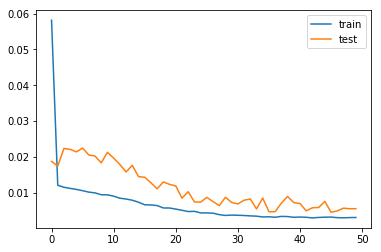

In [76]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [77]:
yhat = model.predict(test_X)
yhat

array([[ 0.93788916,  0.93552285],
       [ 0.93914825,  0.93692648],
       [ 0.94026798,  0.9378199 ],
       ..., 
       [ 0.93209893,  0.93168622],
       [ 0.93264765,  0.93213564],
       [ 0.93263286,  0.93212622]], dtype=float32)

In [78]:
test_y

array([[ 0.94437253,  0.94437253],
       [ 0.94437253,  0.94437253],
       [ 0.94437253,  0.94437253],
       ..., 
       [ 0.93531692,  0.93531692],
       [ 0.93531692,  0.93661058],
       [ 0.93661058,  0.93790424]])

In [79]:
maxT_in = test_scalers[0]
maxT_in

77.300003

In [96]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    '''
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
    '''
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col]*maxT_in - predicted[row, col]*maxT_in)**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score

In [97]:
evaluate_forecasts(test_y, yhat)

0.9987965910530138